# Hands-On NLP - Class 5: Transformers & Large Language Models

**Date:** February 6, 2026

**Goal:** Hands-on experience with the modern State-of-the-Art in NLP.

## The Big Picture

```
    From Previous Notebooks                This Notebook
    ─────────────────────                  ─────────────────────
    
    NB2: Text → TF-IDF → Classifier        Text → Tokenizer → Transformer → Contextualized Embeddings
         (sparse, static)                        (subword, dynamic)
    
    NB3: Word → Word2Vec → Fixed Vector    Word → BERT → Context-Dependent Vector
         ("bank" always same)                    ("bank" differs by context!)
    
    NB4: Embeddings → Feed-Forward NN      Tokens → Self-Attention → All Tasks
         (average, lose order)                   (position-aware, universal)
```

## Notebook Outline

| Part | Topic | Description |
|------|-------|-------------|
| **1** | From Static to Contextual | Why Word2Vec isn't enough |
| **2** | Hugging Face Basics | Loading models, tokenizers, pipelines |
| **3** | Contextual Embeddings | Extracting and comparing BERT embeddings |
| **4** | Masked Language Modeling | BERT's fill-in-the-blank task |
| **5** | Text Generation | GPT-style autoregressive generation |
| **6** | Fine-Tuning (Conceptual) | How to adapt pre-trained models |
| **7** | Practical Pipelines | Zero-shot, NER, Sentiment, QA |
| **8** | The Attention Mechanism | Visualizing what Transformers learn |
| **9** | Ethics & Limitations | Bias, hallucinations, compute costs |
| **10** | Connecting to Previous Notebooks | The full NLP pipeline |

**Key Learning Objectives:**
- Understand the difference between static and contextual embeddings
- Use the Hugging Face `transformers` library fluently
- Extract and analyze contextualized word representations
- Apply pre-trained models to various NLP tasks via pipelines
- Understand the basics of attention and why Transformers work
- Be aware of ethical considerations when using LLMs

## Group Members

🚧 TODO: Fill in your group members' names

* Edna Iusupova
* ...
* ...

---

## Part 1: From Static to Contextual Embeddings

### 1.1 The Limitations of Word2Vec

In Notebook 3, we explored Word2Vec embeddings. These are **static** — each word gets exactly one vector, regardless of context:

| Word | Context 1 | Context 2 | Word2Vec |
|------|-----------|-----------|----------|
| "bank" | "river bank" | "bank account" | Same vector! |
| "bat" | "baseball bat" | "flying bat" | Same vector! |
| "lead" | "lead the team" | "lead poisoning" | Same vector! |

This is a fundamental limitation: **meaning depends on context**.

### 1.2 The Transformer Revolution

Transformers (2017) solved this with **self-attention**: each word's representation is computed by attending to all other words in the sentence.

```
Static (Word2Vec):     word → lookup table → fixed vector

Contextual (BERT):     word + context → attention → dynamic vector
                              ↓
                       Every word "sees" every other word!
```

### 1.3 Pre-trained Language Models

Instead of training embeddings from scratch, we use models pre-trained on massive corpora:

| Model | Training | Parameters | Use Case |
|-------|----------|------------|----------|
| **BERT** | Masked LM (fill blanks) | 110M-340M | Understanding (classification, NER, QA) |
| **GPT-2/3/4** | Next token prediction | 117M-175B | Generation (text, code, chat) |
| **DistilBERT** | Distilled from BERT | 66M | Faster BERT, 97% accuracy |
| **RoBERTa** | Better trained BERT | 125M | Improved classification |

Today we'll use **DistilBERT** — a smaller, faster version of BERT that retains most of its power.

**🚧 TODO:** Before running the code, think about this question: *What types of sentences would you expect to show the biggest difference between Word2Vec and BERT embeddings? Why?*

In [1]:
# Setup: Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import torch

# Hugging Face
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

# Setup
tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
Transformers version: 5.0.0
CUDA available: False


---

## Part 2: Hugging Face Basics

### 2.1 The Hugging Face Ecosystem

Hugging Face provides:
- **`transformers`**: Library for loading and using pre-trained models
- **`datasets`**: Standardized datasets for NLP
- **`tokenizers`**: Fast tokenization
- **Model Hub**: 100,000+ pre-trained models

### 2.2 Loading a Model

Every model has two components:
1. **Tokenizer**: Converts text → token IDs
2. **Model**: Converts token IDs → predictions/embeddings

**🚧 TODO:** Load the `distilbert-base-uncased` tokenizer and model.

In [2]:
model_name = "distilbert-base-uncased"

# 🚧 TODO: Load Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, attn_implementation='eager')

print(f"✓ Loaded {model_name}")
print(f"  Vocab size: {tokenizer.vocab_size:,}")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Loaded distilbert-base-uncased
  Vocab size: 30,522
  Model parameters: 66,362,880


### 2.3 Understanding Tokenization

Unlike Word2Vec which uses whole words, Transformers use **subword tokenization** (WordPiece/BPE):

- Common words stay whole: "the" → `["the"]`
- Rare words are split: "unhappiness" → `["un", "##happiness"]`
- Unknown words decompose: "transformerize" → `["transform", "##er", "##ize"]`

The `##` prefix indicates a continuation of the previous token.

**🚧 TODO:** Explore how the tokenizer handles different words.

In [3]:
# 🚧 TODO: Explore tokenization
test_words = ["transformer", "attention", "unhappiness", "tokenization", "algebra", "theatre"]

for word in test_words:
    tokens = tokenizer.tokenize(word)
    token_ids = tokenizer.encode(word, add_special_tokens=False)
    print(f"{word:50} → {tokens}")

print("\n--- Full sentence tokenization ---")
sentence = "The quick brown fox jumps over the lazy dog."
encoded = tokenizer(sentence, return_tensors="pt")
print(f"Input: {sentence}")
print(f"Token IDs: {encoded['input_ids'][0].tolist()}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])}")
print(f"Decoded back: {tokenizer.decode(encoded['input_ids'][0])}")

transformer                                        → ['transform', '##er']
attention                                          → ['attention']
unhappiness                                        → ['un', '##ha', '##pp', '##iness']
tokenization                                       → ['token', '##ization']
algebra                                            → ['algebra']
theatre                                            → ['theatre']

--- Full sentence tokenization ---
Input: The quick brown fox jumps over the lazy dog.
Token IDs: [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 1012, 102]
Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', '[SEP]']
Decoded back: [CLS] the quick brown fox jumps over the lazy dog. [SEP]


### ❓ Question 1

Why do Transformers use subword tokenization instead of word-level tokenization like Word2Vec?


**Answer:**

*(Your answer here)*


---

## Part 3: Contextual Embeddings

### 3.1 Extracting Hidden States

When we pass text through a Transformer, we get **hidden states** for each token. These are the contextual embeddings!

```python
outputs = model(**inputs)
hidden_states = outputs.last_hidden_state  # Shape: [batch, seq_len, hidden_dim]
```

For DistilBERT: hidden_dim = 768

### 3.2 The "Bank" Experiment

Let's prove that Transformers give different vectors for the same word in different contexts.

**🚧 TODO:**
1. Embed: "I went to the **bank** to fetch water."
2. Embed: "I went to the **bank** to deposit money."
3. Extract the vector for "bank" in both cases.
4. Compute cosine similarity. Are they identical?

In [4]:
text1 = "I went to the bank to fetch water."
text2 = "I went to the bank to deposit money."

# 🚧 TODO: Tokenize and run model inference
inputs1 = tokenizer(text1, return_tensors="pt")
inputs2 = tokenizer(text2, return_tensors="pt")


with torch.no_grad():
    out1 = model(**inputs1)
    out2 = model(**inputs2)

# Hidden states: [batch, seq_len, hidden_dim]
hidden1 = out1.last_hidden_state[0]
hidden2 = out2.last_hidden_state[0]

print(f"Sentence 1: {text1}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(inputs1['input_ids'][0])}")
print(f"Hidden states shape: {hidden1.shape}")
print()
print(f"Sentence 2: {text2}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(inputs2['input_ids'][0])}")

Sentence 1: I went to the bank to fetch water.
Tokens: ['[CLS]', 'i', 'went', 'to', 'the', 'bank', 'to', 'fetch', 'water', '.', '[SEP]']
Hidden states shape: torch.Size([11, 768])

Sentence 2: I went to the bank to deposit money.
Tokens: ['[CLS]', 'i', 'went', 'to', 'the', 'bank', 'to', 'deposit', 'money', '.', '[SEP]']


In [5]:
# 🚧 TODO: Find the index of "bank" and extract its vector
bank_token_id = tokenizer.encode("bank", add_special_tokens=False)[0]
idx1 = (inputs1.input_ids[0] == bank_token_id).nonzero(as_tuple=True)[0][0]
idx2 = (inputs2.input_ids[0] == bank_token_id).nonzero(as_tuple=True)[0][0]

print(f"'bank' token ID: {bank_token_id}")
print(f"Position of 'bank' in sentence 1: {idx1.item()}")
print(f"Position of 'bank' in sentence 2: {idx2.item()}")

# Extract the contextual embedding for "bank" in each sentence
bank_vec1 = hidden1[idx1]
bank_vec2 = hidden2[idx2]

print(f"\nVector shape: {bank_vec1.shape}")

'bank' token ID: 2924
Position of 'bank' in sentence 1: 5
Position of 'bank' in sentence 2: 5

Vector shape: torch.Size([768])


In [6]:
# 🚧 TODO: Compute cosine similarity between the two "bank" vectors
cos_sim = torch.nn.functional.cosine_similarity(bank_vec1.unsqueeze(0), bank_vec2.unsqueeze(0))

print(f"Cosine similarity between 'bank' (river) and 'bank' (money): {cos_sim.item():.4f}")
print()

if cos_sim < 0.9:
    print("✓ The vectors are DIFFERENT! The model distinguishes the two meanings.")
else:
    print("✗ The vectors are very similar. This is unexpected for contextual embeddings.")

# For comparison: what would Word2Vec give?
print("\n--- Comparison with Word2Vec ---")
print("Word2Vec would give: cosine_similarity = 1.0000 (identical vectors)")
print(f"BERT gives:         cosine_similarity = {cos_sim.item():.4f} (context-aware!)")

Cosine similarity between 'bank' (river) and 'bank' (money): 0.8783

✓ The vectors are DIFFERENT! The model distinguishes the two meanings.

--- Comparison with Word2Vec ---
Word2Vec would give: cosine_similarity = 1.0000 (identical vectors)
BERT gives:         cosine_similarity = 0.8783 (context-aware!)


### 3.3 More Polysemy Examples

Let's explore more words with multiple meanings to verify contextual awareness.

**🚧 TODO:** Compare embeddings for other polysemous words.

In [7]:
def get_word_embedding(sentence, target_word):
    """Extract the contextual embedding for a target word in a sentence."""
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    hidden = outputs.last_hidden_state[0]
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Find target word index
    target_id = tokenizer.convert_tokens_to_ids(target_word.lower())
    indices = (inputs.input_ids[0] == target_id).nonzero(as_tuple=True)[0]

    if len(indices) == 0:
        # Try finding as subword
        for i, tok in enumerate(tokens):
            if target_word.lower() in tok:
                return hidden[i]
        raise ValueError(f"'{target_word}' not found in tokens: {tokens}")

    return hidden[indices[0]]

# Test cases: polysemous words
polysemy_tests = [
    ("bat", "The bat flew out of the cave.", "He swung the bat at the ball."),
    ("lead", "She will lead the team to victory.", "Lead poisoning is dangerous."),
    ("spring", "The flowers bloom in spring.", "The spring in the mattress broke."),
    ("match", "Light a match to start the fire.", "They watched the tennis match."),
]

print("Polysemy Analysis: Same word, different meanings\n")
print(f"{'Word':<10} {'Similarity':<12} {'Context 1':<40} {'Context 2'}")
print("=" * 110)

for word, sent1, sent2 in polysemy_tests:
    try:
        vec1 = get_word_embedding(sent1, word)
        vec2 = get_word_embedding(sent2, word)
        sim = torch.nn.functional.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()
        print(f"{word:<10} {sim:.4f}       {sent1[:38]:<40} {sent2[:40]}")
    except ValueError as e:
        print(f"{word:<10} ERROR: {e}")



Polysemy Analysis: Same word, different meanings

Word       Similarity   Context 1                                Context 2
bat        0.7092       The bat flew out of the cave.            He swung the bat at the ball.
lead       0.4083       She will lead the team to victory.       Lead poisoning is dangerous.
spring     0.5727       The flowers bloom in spring.             The spring in the mattress broke.
match      0.6121       Light a match to start the fire.         They watched the tennis match.


BAT Ambiguity Experiment

1. ANIMAL:    'The bat flew out of the cave.'
2. SPORTS:    'He swung the bat at the ball.'
3. AMBIGUOUS: 'I saw a bat in the park.'
4. SLANG:     'Contextual embeddings are bat shit crazy!'

📊 Similarity Matrix:
   Animal ↔ Sports:    0.7092  (the two distinct meanings)
   Ambiguous ↔ Animal: 0.8693
   Ambiguous ↔ Sports: 0.7720
   Slang ↔ Animal:     0.7146
   Slang ↔ Sports:     0.5670

   Average similarity (ambiguous) to both: 0.8206

✓ The ambiguous 'bat' is MORE similar to BOTH meanings than they are to each other!
  → The model captures the uncertainty by placing the vector 'between' the two meanings.


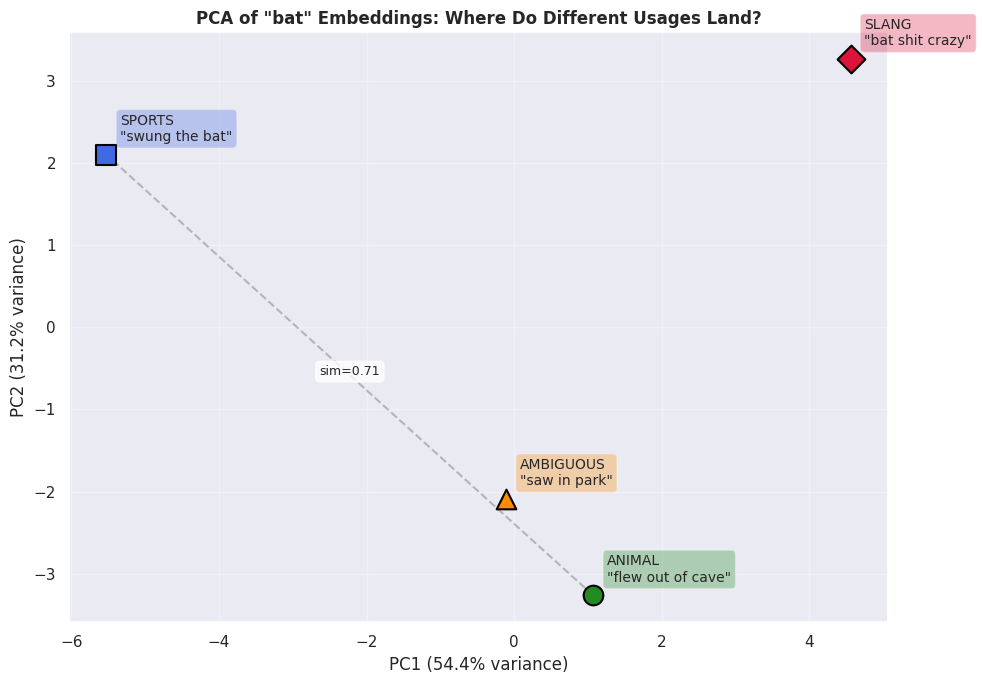


📊 Interpretation:
   SLANG 'bat shit crazy' is closest to: ANIMAL
   This makes sense — the idiom derives from the animal (bat guano), not sports!


In [8]:
# Ambiguity experiment: Does an ambiguous sentence fall BETWEEN the two meanings?

# Unambiguous sentences (from polysemy_tests above)
bat_animal = "The bat flew out of the cave."
bat_sports = "He swung the bat at the ball."

# Ambiguous sentence - could be either meaning!
bat_ambiguous = "I saw a bat in the park."

# Idiomatic/slang usage - what happens here?
bat_slang = "Contextual embeddings are bat shit crazy!"

# Get embeddings
vec_animal = get_word_embedding(bat_animal, "bat")
vec_sports = get_word_embedding(bat_sports, "bat")
vec_ambiguous = get_word_embedding(bat_ambiguous, "bat")
vec_slang = get_word_embedding(bat_slang, "bat")

# Compute similarities
sim_animal_sports = torch.nn.functional.cosine_similarity(vec_animal.unsqueeze(0), vec_sports.unsqueeze(0)).item()
sim_ambig_animal = torch.nn.functional.cosine_similarity(vec_ambiguous.unsqueeze(0), vec_animal.unsqueeze(0)).item()
sim_ambig_sports = torch.nn.functional.cosine_similarity(vec_ambiguous.unsqueeze(0), vec_sports.unsqueeze(0)).item()
sim_slang_animal = torch.nn.functional.cosine_similarity(vec_slang.unsqueeze(0), vec_animal.unsqueeze(0)).item()
sim_slang_sports = torch.nn.functional.cosine_similarity(vec_slang.unsqueeze(0), vec_sports.unsqueeze(0)).item()

print("BAT Ambiguity Experiment")
print("=" * 70)
print(f"\n1. ANIMAL:    '{bat_animal}'")
print(f"2. SPORTS:    '{bat_sports}'")
print(f"3. AMBIGUOUS: '{bat_ambiguous}'")
print(f"4. SLANG:     '{bat_slang}'")

print(f"\n📊 Similarity Matrix:")
print(f"   Animal ↔ Sports:    {sim_animal_sports:.4f}  (the two distinct meanings)")
print(f"   Ambiguous ↔ Animal: {sim_ambig_animal:.4f}")
print(f"   Ambiguous ↔ Sports: {sim_ambig_sports:.4f}")
print(f"   Slang ↔ Animal:     {sim_slang_animal:.4f}")
print(f"   Slang ↔ Sports:     {sim_slang_sports:.4f}")

# Check if ambiguous is "between" the two meanings
avg_to_both = (sim_ambig_animal + sim_ambig_sports) / 2
print(f"\n   Average similarity (ambiguous) to both: {avg_to_both:.4f}")

print("\n" + "=" * 70)
if sim_ambig_animal > sim_animal_sports and sim_ambig_sports > sim_animal_sports:
    print("✓ The ambiguous 'bat' is MORE similar to BOTH meanings than they are to each other!")
    print("  → The model captures the uncertainty by placing the vector 'between' the two meanings.")
else:
    # Check which meaning dominates
    if sim_ambig_animal > sim_ambig_sports:
        print(f"→ The ambiguous sentence leans toward ANIMAL meaning ({sim_ambig_animal:.4f} > {sim_ambig_sports:.4f})")
        print("  Perhaps 'park' evokes nature/wildlife more than sports?")
    else:
        print(f"→ The ambiguous sentence leans toward SPORTS meaning ({sim_ambig_sports:.4f} > {sim_ambig_animal:.4f})")
        print("  Perhaps 'park' evokes baseball parks?")

# Visualize with PCA - project 768-dim vectors to 2D
from sklearn.decomposition import PCA

# Stack vectors and reduce to 2D
vectors = torch.stack([vec_animal, vec_sports, vec_ambiguous, vec_slang]).numpy()
pca = PCA(n_components=2)
coords = pca.fit_transform(vectors)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot points
colors = ['forestgreen', 'royalblue', 'darkorange', 'crimson']
labels = ['ANIMAL\n"flew out of cave"', 'SPORTS\n"swung the bat"', 'AMBIGUOUS\n"saw in park"', 'SLANG\n"bat shit crazy"']
markers = ['o', 's', '^', 'D']

for i, (label, color, marker) in enumerate(zip(labels, colors, markers)):
    ax.scatter(coords[i, 0], coords[i, 1], c=color, s=200, marker=marker,
               edgecolors='black', linewidths=1.5, zorder=5)
    ax.annotate(label, (coords[i, 0], coords[i, 1]),
                textcoords="offset points", xytext=(10, 10), fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

# Draw lines between animal and sports (the main axis of meaning)
ax.plot([coords[0, 0], coords[1, 0]], [coords[0, 1], coords[1, 1]],
        '--', color='gray', alpha=0.5, linewidth=1.5)
mid = ((coords[0, 0] + coords[1, 0])/2, (coords[0, 1] + coords[1, 1])/2)
ax.annotate(f'sim={sim_animal_sports:.2f}', mid, fontsize=9, ha='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA of "bat" Embeddings: Where Do Different Usages Land?', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation
print("\n📊 Interpretation:")
print(f"   SLANG 'bat shit crazy' is closest to: {'ANIMAL' if sim_slang_animal > sim_slang_sports else 'SPORTS'}")
print(f"   This makes sense — the idiom derives from the animal (bat guano), not sports!")

### ❓ Question 2

What is the [CLS] token and why is it useful for classification?


**Answer:**

*(Your answer here)*


---

## Part 4: Masked Language Modeling (MLM)

### 4.1 How BERT Was Trained

BERT uses **Masked Language Modeling**: randomly mask 15% of tokens and train the model to predict them.

```
Input:   "The cat sat on the [MASK]."
Target:  "mat"

Input:   "I [MASK] to the store yesterday."  
Target:  "went"
```

This forces the model to learn deep bidirectional context — it must understand the whole sentence to fill in the blank.

### 4.2 Using MLM for Fill-in-the-Blank

We can use a pre-trained MLM model to predict masked words!

**🚧 TODO:** Predict the masked word in: "The capital of France is [MASK]."

In [9]:
# Load model with LM head (for masked prediction)
model_mlm = AutoModelForMaskedLM.from_pretrained(model_name)

text_masked = "The capital of France is [MASK]."
inputs = tokenizer(text_masked, return_tensors="pt")

print(f"Input: {text_masked}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])}")

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

Input: The capital of France is [MASK].
Tokens: ['[CLS]', 'the', 'capital', 'of', 'france', 'is', '[MASK]', '.', '[SEP]']


In [10]:
# 🚧 TODO: Get predictions for the masked token
with torch.no_grad():
    outputs = model_mlm(**inputs)
    logits = outputs.logits

# Find [MASK] token position
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

# Get logits for the [MASK] position
mask_token_logits = logits[0, mask_token_index, :]

# Get top 5 predictions
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

print(f"\nTop 5 predictions for [MASK]:")
for i, token in enumerate(top_5_tokens, 1):
    word = tokenizer.decode([token])
    prob = torch.softmax(mask_token_logits, dim=1)[0, token].item()
    filled = text_masked.replace("[MASK]", word)
    print(f"  {i}. {word:<15} (prob: {prob:.4f})  →  \"{filled}\"")


Top 5 predictions for [MASK]:
  1. marseille       (prob: 0.1427)  →  "The capital of France is marseille."
  2. nantes          (prob: 0.0902)  →  "The capital of France is nantes."
  3. toulouse        (prob: 0.0881)  →  "The capital of France is toulouse."
  4. paris           (prob: 0.0862)  →  "The capital of France is paris."
  5. lyon            (prob: 0.0772)  →  "The capital of France is lyon."


### 4.3 Interactive MLM (Masked Language Modeling) Explorer

Let's create a function to explore MLM predictions on any sentence.

**🚧 TODO:** Try different sentences and see what the model predicts.

In [11]:
def predict_mask(text, top_k=5):
    """Predict top-k words for [MASK] in text."""
    if "[MASK]" not in text:
        raise ValueError("Text must contain [MASK]")

    inputs = tokenizer(text, return_tensors="pt")

    with torch.no_grad():
        logits = model_mlm(**inputs).logits

    mask_idx = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    mask_logits = logits[0, mask_idx, :]
    probs = torch.softmax(mask_logits, dim=1)

    top_tokens = torch.topk(probs, top_k, dim=1)

    results = []
    for i in range(top_k):
        token_id = top_tokens.indices[0, i].item()
        prob = top_tokens.values[0, i].item()
        word = tokenizer.decode([token_id])
        results.append((word, prob, text.replace("[MASK]", word)))

    return results

# Test with various sentences
test_sentences = [
    "The doctor told the [MASK] to take the medicine.",
    "She studies [MASK] at the university.",
    "Python is a popular [MASK] language.",
    "The [MASK] of the United States lives in the White House.",
    "I had [MASK] for breakfast this morning.",
]

for sent in test_sentences:
    print(f"\n📝 {sent}")
    predictions = predict_mask(sent, top_k=3)
    for word, prob, filled in predictions:
        print(f"   → {word:<12} ({prob:.2%})")


📝 The doctor told the [MASK] to take the medicine.
   → patient      (11.03%)
   → nurse        (10.67%)
   → doctor       (5.89%)

📝 She studies [MASK] at the university.
   → journalism   (10.16%)
   → economics    (9.20%)
   → law          (6.99%)

📝 Python is a popular [MASK] language.
   → programming  (90.44%)
   → python       (5.64%)
   → modeling     (0.67%)

📝 The [MASK] of the United States lives in the White House.
   → president    (92.61%)
   → ambassador   (4.25%)
   → embassy      (0.50%)

📝 I had [MASK] for breakfast this morning.
   → breakfast    (23.97%)
   → pancakes     (5.13%)
   → coffee       (4.57%)


### ❓ Question 3

What biases might we observe in MLM predictions? How could we detect them?


**Answer:**

*(Your answer here)*


In [12]:
# Bias detection example: gender associations with professions
profession_sentences = [
    "The [MASK] works as a nurse.",
    "The [MASK] works as an engineer.",
    "The [MASK] works as a teacher.",
    "The [MASK] works as a programmer.",
    "The [MASK] works as a secretary.",
]

print("Gender Bias Analysis in Profession Associations")
print("=" * 60)
print(f"{'Profession':<20} {'Top Prediction':<15} {'he prob':<12} {'she prob':<12}")
print("-" * 60)

for sent in profession_sentences:
    inputs = tokenizer(sent, return_tensors="pt")
    with torch.no_grad():
        logits = model_mlm(**inputs).logits

    mask_idx = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    probs = torch.softmax(logits[0, mask_idx, :], dim=1)

    he_prob = probs[0, tokenizer.convert_tokens_to_ids("he")].item()
    she_prob = probs[0, tokenizer.convert_tokens_to_ids("she")].item()

    top_token = tokenizer.decode([probs.argmax().item()])
    profession = sent.split("as a")[1].strip().rstrip(".")

    print(f"{profession:<20} {top_token:<15} {he_prob:.4f}       {she_prob:.4f}")

print("\n⚠️ Note: These biases reflect training data, not reality!")

Gender Bias Analysis in Profession Associations
Profession           Top Prediction  he prob      she prob    
------------------------------------------------------------
nurse                girl            0.0000       0.0002
n engineer           artist          0.0002       0.0000
teacher              artist          0.0000       0.0001
programmer           player          0.0001       0.0000
secretary            principal       0.0001       0.0002

⚠️ Note: These biases reflect training data, not reality!


---

## Part 5: Text Generation with GPT

### 5.1 Autoregressive Language Models

While BERT fills in blanks (bidirectional), **GPT** models predict the next token (left-to-right):

```
BERT:   "The [MASK] sat on the mat"     →  predicts "cat"
GPT:    "The cat sat on the"            →  predicts "mat"
```

**Autoregressive generation**: Generate one token, append it, repeat.

```
Prompt:     "Once upon a"
Step 1:     "Once upon a" → "time"     → "Once upon a time"
Step 2:     "Once upon a time" → ","   → "Once upon a time,"
Step 3:     "Once upon a time," → "there" → "Once upon a time, there"
...
```

### 5.2 Loading GPT-2

**🚧 TODO:** Load GPT-2 and generate text from a prompt.

In [13]:
from transformers import AutoModelForCausalLM

# 🚧 TODO: Load GPT-2
model_name_gpt = "gpt2"
tokenizer_gpt = AutoTokenizer.from_pretrained(model_name_gpt)
model_gpt = AutoModelForCausalLM.from_pretrained(model_name_gpt)

# GPT-2 doesn't have a pad token by default.
# Why? GPT-2 was trained for generation (left-to-right), not batched classification.
# We set pad_token = eos_token as a workaround for batch processing.
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

print(f"✓ Loaded GPT-2")

print(f"  Vocab size: {tokenizer_gpt.vocab_size:,}")
print(f"  Parameters: {sum(p.numel() for p in model_gpt.parameters()):,}")

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Loaded GPT-2
  Vocab size: 50,257
  Parameters: 124,439,808


In [14]:
prompt = "Short description of the Traveling salesman problem"

inputs = tokenizer_gpt(prompt, return_tensors="pt")

# Generate with different strategies
with torch.no_grad():
    # Greedy decoding (always pick most likely token)
    greedy_output = model_gpt.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=False,
        pad_token_id=tokenizer_gpt.eos_token_id
    )

    # Sampling with temperature
    sampled_output = model_gpt.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        pad_token_id=tokenizer_gpt.eos_token_id
    )

print(f"Prompt: {prompt}\n")
print("=" * 60)
print("GREEDY (deterministic):")
print(tokenizer_gpt.decode(greedy_output[0], skip_special_tokens=True))
print("\n" + "=" * 60)
print("SAMPLED (temperature=0.7):")
print(tokenizer_gpt.decode(sampled_output[0], skip_special_tokens=True))

Prompt: Short description of the Traveling salesman problem

GREEDY (deterministic):
Short description of the Traveling salesman problem.

The Traveling salesman problem is a problem that can be solved by using a combination of two or more of the following:

A combination of two or more of the following:

A combination of two or more of the following

SAMPLED (temperature=0.7):
Short description of the Traveling salesman problem:

The Traveling salesman is a salesman who is not familiar with the business. He is in charge of a business and therefore cannot be trusted. He will tell you what is happening and then will tell you what you need to know. He


### 5.3 Decoding Strategies

How we select the next token dramatically affects generation quality:

| Strategy | Description | Pros | Cons |
|----------|-------------|------|------|
| **Greedy** | Always pick highest probability | Fast, deterministic | Repetitive, boring |
| **Temperature** | Scale logits by T before softmax | Controls randomness | T→0: greedy, T→∞: random |
| **Top-k** | Sample from top k tokens only | Avoids unlikely tokens | Fixed k may be wrong |
| **Top-p (nucleus)** | Sample from smallest set with prob ≥ p | Adapts to confidence | Slightly slower |
| **Beam Search** | Keep top-b partial sequences | Better global coherence | Expensive, still repetitive |

**Temperature intuition:**
- $T = 1.0$: Original probabilities
- $T < 1.0$: Sharper distribution (more greedy)
- $T > 1.0$: Flatter distribution (more random)

**🚧 TODO:** Experiment with different decoding parameters.

In [15]:
# 🚧 TODO: Compare different temperature values

temperatures = [0.3, 0.7, 1.0, 1.5]
inputs = tokenizer_gpt(prompt, return_tensors="pt")

print(f"Prompt: {prompt}\n")
print("=" * 70)

for temp in temperatures:
    with torch.no_grad():
        output = model_gpt.generate(
            **inputs,
            max_new_tokens=30,
            do_sample=True,
            temperature=temp,
            top_k=50,
            pad_token_id=tokenizer_gpt.eos_token_id
        )
    text = tokenizer_gpt.decode(output[0], skip_special_tokens=True)
    print(f"T={temp}: {text}")
    print()

Prompt: Short description of the Traveling salesman problem

T=0.3: Short description of the Traveling salesman problem:

The Traveling salesman is a salesman who is not a salesman. He is a salesman who is not a salesman. He is a salesman

T=0.7: Short description of the Traveling salesman problem. It has been mentioned that the salesman's job is to make sure that the salesman doesn't make the salesman too lazy. The salesman will

T=1.0: Short description of the Traveling salesman problem

T=1.5: Short description of the Traveling salesman problem has grown since the day the article was published. From the start there wasn't much question as to whether the salesman could use those words, and from



### ❓ Question 4

Why does GPT sometimes generate repetitive text, and how do decoding strategies help?


**Answer:**

*(Your answer here)*


### 5.4 Base Models vs. Instruct/Chat Models

The GPT-2 model we just used is a **Base Model** (or Completion Model).
- **Training**: Trained on raw text (Wikipedia, books, web) to predict the next token.
- **Behavior**: It "continues" the text. If you ask "What is Paris?", it might reply "...and why should you visit?"

Modern "AI" (like ChatGPT, Llama 3 Chat, Claude) are **Instruction Tuned**:
- **Training**: Base Model + Fine-Tuning on (Instruction, Response) pairs + RLHF (Reinforcement Learning from Human Feedback).
- **Behavior**: They "follow instructions". If you ask "What is Paris?", they reply "Paris is the capital of France..."

**Demonstration of the difference:**
Base models often need **Prompt Engineering** (like "few-shot" examples) to answer questions, whereas chat models just need the question.

In [16]:
# 🚧 TODO: Run this to see how Base Models need help to act like generic Chatbots
    # ...

naive_prompt = "What is the capital of France?"

# Trick: Make it look like a QA document (Few-Shot Prompting)
engineered_prompt = """
Q: What is the capital of Germany?
A: Berlin.

Q: What is the capital of France?
A:"""

print("--- Naive Prompt (Base Model) ---")
inputs = tokenizer_gpt(naive_prompt, return_tensors="pt")
out = model_gpt.generate(**inputs, max_new_tokens=20, pad_token_id=tokenizer_gpt.eos_token_id)
print(tokenizer_gpt.decode(out[0], skip_special_tokens=True))

print("\n--- Engineered Prompt (Few-Shot) ---")
inputs = tokenizer_gpt(engineered_prompt, return_tensors="pt")
out = model_gpt.generate(**inputs, max_new_tokens=5, pad_token_id=tokenizer_gpt.eos_token_id)
print(tokenizer_gpt.decode(out[0], skip_special_tokens=True))

--- Naive Prompt (Base Model) ---
What is the capital of France?

The capital of France is Paris.

The capital of France is Paris.



--- Engineered Prompt (Few-Shot) ---

Q: What is the capital of Germany?
A: Berlin.

Q: What is the capital of France?
A: Paris.

Q


---

## Part 6: Fine-Tuning (Conceptual)

### 6.1 Transfer Learning in NLP

Pre-trained models are trained on general text (Wikipedia, books, web). To use them for specific tasks, we **fine-tune**:

```
PRE-TRAINING (expensive, done once)
───────────────────────────────────
Massive corpus → Train from scratch → General model
(100GB+ text)    (weeks on GPUs)      (BERT, GPT)

FINE-TUNING (cheap, do many times)
───────────────────────────────────
Your dataset → Train on top → Task-specific model
(1K-100K examples)  (hours)     (Sentiment classifier)
```

### 6.2 Fine-Tuning Approaches

| Approach | What's Trained | Use Case |
|----------|---------------|----------|
| **Full fine-tuning** | All parameters | Best quality, most compute |
| **Feature extraction** | Only classifier head | Fast, small datasets |
| **LoRA/Adapters** | Small additional layers | Efficient, preserves base |
| **Prompt tuning** | Soft prompt embeddings | Very efficient, recent |

### 6.3 Classification Architecture

For classification, we add a simple head on top of BERT:

```
Text → BERT → [CLS] embedding (768d) → Linear (768 → num_classes) → Softmax
                     ↑
            This captures sentence meaning
```

**🚧 TODO:** Understand the architecture conceptually (we won't run full fine-tuning due to time).

In [17]:
import torch.nn as nn

class BertClassifier(nn.Module):
    """A simple classifier on top of BERT."""

    def __init__(self, bert_model, num_classes, freeze_bert=False):
        super().__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(768, num_classes)  # 768 = BERT hidden size
        self.dropout = nn.Dropout(0.1)

        if freeze_bert:
            # Feature extraction: only train classifier
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [batch, 768]

        # Classify
        x = self.dropout(cls_embedding)
        logits = self.classifier(x)  # [batch, num_classes]

        return logits

# Example: create a sentiment classifier (pos/neg/neutral)
num_classes = 3
classifier = BertClassifier(model, num_classes, freeze_bert=True)

# Count trainable parameters
total_params = sum(p.numel() for p in classifier.parameters())
trainable_params = sum(p.numel() for p in classifier.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")
print(f"\n→ With freeze_bert=True, we only train {trainable_params:,} params instead of {total_params:,}!")

# 🚧 TODO: Study the BertClassifier class above and answer:
    # ...
# 1. What does freeze_bert=True do? Why would we use it?
# 2. Why do we use dropout before the classifier? What does it prevent?
# 3. Why index [:, 0, :] for the [CLS] token specifically?

print("\n🚧 ANSWERS (Solutions):")
print("=" * 60)
print("\n1. freeze_bert=True:")

print("   Sets requires_grad=False for all BERT parameters.")
print("   Result: [batch_size, 768] — the sentence embeddings")

print("   This means BERT weights stay fixed during training.")
print("     - All 768 hidden dimensions (:)")

print("   Use when: small dataset, limited compute, or want fast training.")
print("     - First token position (0) → this is always [CLS]")

print("   Trade-off: Slightly lower accuracy but MUCH faster training.")
print("     - All samples in batch (:)")

print("   (Training 2,304 params vs 66+ million!)")
print("   [:, 0, :] selects:")

print("   Shape of last_hidden_state: [batch_size, seq_len, hidden_dim]")

print("\n2. dropout:")
print("\n3. [:, 0, :] indexing:")

print("   Randomly zeros 10% of features during training.")

print("   Prevents OVERFITTING: stops the classifier from relying")
print("   At inference time, dropout is disabled (model.eval()).")
print("   too heavily on any single feature of the [CLS] embedding.")

Total parameters: 66,365,187
Trainable parameters: 2,307
Frozen parameters: 66,362,880

→ With freeze_bert=True, we only train 2,307 params instead of 66,365,187!

🚧 ANSWERS (Solutions):

1. freeze_bert=True:
   Sets requires_grad=False for all BERT parameters.
   Result: [batch_size, 768] — the sentence embeddings
   This means BERT weights stay fixed during training.
     - All 768 hidden dimensions (:)
   Use when: small dataset, limited compute, or want fast training.
     - First token position (0) → this is always [CLS]
   Trade-off: Slightly lower accuracy but MUCH faster training.
     - All samples in batch (:)
   (Training 2,304 params vs 66+ million!)
   [:, 0, :] selects:
   Shape of last_hidden_state: [batch_size, seq_len, hidden_dim]

2. dropout:

3. [:, 0, :] indexing:
   Randomly zeros 10% of features during training.
   Prevents OVERFITTING: stops the classifier from relying
   At inference time, dropout is disabled (model.eval()).
   too heavily on any single feature 

---

## Part 7: Practical Pipelines

### 7.1 Hugging Face Pipelines

Pipelines are the easiest way to use pre-trained models for common tasks:

```python
from transformers import pipeline

# One line to load and use any NLP task!
classifier = pipeline("sentiment-analysis")
result = classifier("I love this product!")
```

Available pipelines: `sentiment-analysis`, `ner`, `question-answering`, `summarization`, `translation`, `text-generation`, `zero-shot-classification`, and more!

**🚧 TODO:** Explore different pipelines.

In [18]:
from transformers import pipeline

# 🚧 TODO: Sentiment Analysis Pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

texts = [
    "I absolutely love this new restaurant!",
    "The service was terrible and the food was cold.",
    "It was okay, nothing special.",
    "Best experience of my life!",
]

print("Sentiment Analysis")
print("=" * 60)
for text in texts:
    result = sentiment_analyzer(text)[0]
    print(f"[{result['label']:>8}] ({result['score']:.2%}) {text}")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f.
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Sentiment Analysis
[POSITIVE] (99.99%) I absolutely love this new restaurant!
[NEGATIVE] (99.97%) The service was terrible and the food was cold.
[NEGATIVE] (98.21%) It was okay, nothing special.
[POSITIVE] (99.98%) Best experience of my life!


In [19]:
# 🚧 TODO: Named Entity Recognition (NER) Pipeline
ner = pipeline("ner")

text = "Apple Inc. was founded by Steve Jobs in Cupertino, California in 1976."

print("Named Entity Recognition")
print("=" * 60)
print(f"Text: {text}\n")

entities = ner(text)
for ent in entities:
    print(f"  [{ent['entity']:>10}] {ent['word']:<20} (score: {ent['score']:.2%})")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496.
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: dbmdz/bert-large-cased-finetuned-conll03-english
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.bias   | UNEXPECTED |  | 
bert.pooler.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Named Entity Recognition
Text: Apple Inc. was founded by Steve Jobs in Cupertino, California in 1976.

  [     I-ORG] Apple                (score: 99.97%)
  [     I-ORG] Inc                  (score: 99.95%)
  [     I-PER] Steve                (score: 99.90%)
  [     I-PER] Job                  (score: 99.94%)
  [     I-PER] ##s                  (score: 96.90%)
  [     I-LOC] Cup                  (score: 99.71%)
  [     I-LOC] ##ert                (score: 92.67%)
  [     I-LOC] ##ino                (score: 99.61%)
  [     I-LOC] California           (score: 99.90%)


In [20]:
# 🚧 TODO: Zero-Shot Classification
zero_shot = pipeline("zero-shot-classification")
# This is incredibly powerful - classify without training!

text = "The revolution is not an apple that falls when it is ripe. You have to make it fall." # Che Guevara!
candidate_labels = ["politics", "agriculture", "philosophy", "cooking", "sports"]

print("Zero-Shot Classification")
print("=" * 60)
print(f"Text: {text}\n")

result = zero_shot(text, candidate_labels)
for label, score in zip(result['labels'], result['scores']):
    bar = "█" * int(score * 30)
    print(f"  {label:<15} {score:.2%} {bar}")

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1.
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

Zero-Shot Classification
Text: The revolution is not an apple that falls when it is ripe. You have to make it fall.

  philosophy      37.52% ███████████
  politics        24.97% ███████
  cooking         21.73% ██████
  agriculture     10.22% ███
  sports          5.55% █


In [21]:
# 🚧 TODO: Question Answering
    # ...
qa = pipeline("question-answering")
context = """
The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France.
It is named after the engineer Gustave Eiffel, whose company designed and built the tower.
Constructed from 1887 to 1889 as the centerpiece of the 1889 World's Fair, it was initially
criticized by some of France's leading artists and intellectuals. The tower is 330 metres
(1,083 ft) tall and is the tallest structure in Paris.
"""

questions = [
    "Who designed the Eiffel Tower?",
    "How tall is the Eiffel Tower?",
    "When was the Eiffel Tower built?",
    "Where is the Eiffel Tower located?",
]

print("Question Answering")
print("=" * 60)
print(f"Context: {context[:100]}...\n")

for q in questions:
    result = qa(question=q, context=context)
    print(f"Q: {q}")
    print(f"A: {result['answer']} (confidence: {result['score']:.2%})")
    print()

# 🚧 TODO: Try adding your own question that CANNOT be answered from the context.
    # ...
# What does the model do? Does it admit it doesn't know, or does it hallucinate?

print("\n" + "=" * 60)
print("Testing UNANSWERABLE questions:")
print("=" * 60)

unanswerable_questions = [
    "What color is the Eiffel Tower?",
    "How much does a ticket cost?",
    "Who painted the Eiffel Tower?",
]

for my_question in unanswerable_questions:
    result = qa(question=my_question, context=context)
    print(f"\n🚧 Q: {my_question}")
    print(f"   Model's answer: '{result['answer']}' (confidence: {result['score']:.2%})")

    # Check if confidence is low
    if result['score'] < 0.3:
        print("   → Low confidence suggests model is uncertain (good!)")
    else:
        print("   → ⚠️ High confidence despite question being unanswerable!")

print("\n" + "=" * 60)
print("📊 ANALYSIS (Solutions):")
print("=" * 60)
print("The QA model does NOT admit when it doesn't know!")
print("Instead, it extracts the 'best' span from the context, even if wrong.")
print("")
print("This is a FUNDAMENTAL LIMITATION of extractive QA:")
print("  - The model MUST return a span from the context")
print("  - It cannot say 'I don't know' or 'Not in context'")
print("  - Low confidence scores are the only hint of uncertainty")
print("")
print("Modern QA systems (like SQuAD 2.0 models) are trained to")
print("detect unanswerable questions, but this basic model cannot.")

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5.
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading weights:   0%|          | 0/102 [00:00<?, ?it/s]

Question Answering
Context: 
The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. 
It is name...

Q: Who designed the Eiffel Tower?
A: Gustave Eiffel (confidence: 99.20%)

Q: How tall is the Eiffel Tower?
A: 330 metres 
(1,083 ft) (confidence: 35.22%)

Q: When was the Eiffel Tower built?
A: 1887 to 1889 (confidence: 40.18%)

Q: Where is the Eiffel Tower located?
A: Champ de Mars in Paris, France (confidence: 38.24%)


Testing UNANSWERABLE questions:

🚧 Q: What color is the Eiffel Tower?
   Model's answer: 'Champ de Mars in Paris, France' (confidence: 2.70%)
   → Low confidence suggests model is uncertain (good!)

🚧 Q: How much does a ticket cost?
   Model's answer: '330 metres' (confidence: 31.58%)
   → ⚠️ High confidence despite question being unanswerable!

🚧 Q: Who painted the Eiffel Tower?
   Model's answer: 'Gustave Eiffel' (confidence: 40.58%)
   → ⚠️ High confidence despite question being unanswerable!

📊 ANALYSIS (Solutions):
The QA model does

---

## Part 8: The Attention Mechanism

### 8.1 What is Attention?

The key innovation of Transformers is **self-attention**: each token can "attend" to every other token in the sequence.

**Intuition**: When computing the representation of "bank" in "I went to the bank to deposit money", the model should focus on "deposit" and "money" more than "I" or "went".

### 8.2 Attention Formula

For each token, we compute:
1. **Query (Q)**: "What am I looking for?"
2. **Key (K)**: "What do I contain?"
3. **Value (V)**: "What information do I provide?"

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The softmax gives us **attention weights** — how much each token focuses on each other token.

### 8.3 Visualizing Attention

Let's see what tokens BERT attends to when processing text.

**🚧 TODO:** Visualize attention patterns.

In [22]:
# Get attention weights from the model
text = "The cat sat on the mat because it was tired."

# Need to request attention outputs
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# outputs.attentions is a tuple: one tensor per layer
# Each tensor: [batch, num_heads, seq_len, seq_len]
attentions = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print(f"Number of layers: {len(attentions)}")
print(f"Attention shape per layer: {attentions[0].shape}")
print(f"Tokens: {tokens}")

Number of layers: 6
Attention shape per layer: torch.Size([1, 12, 13, 13])
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', 'because', 'it', 'was', 'tired', '.', '[SEP]']


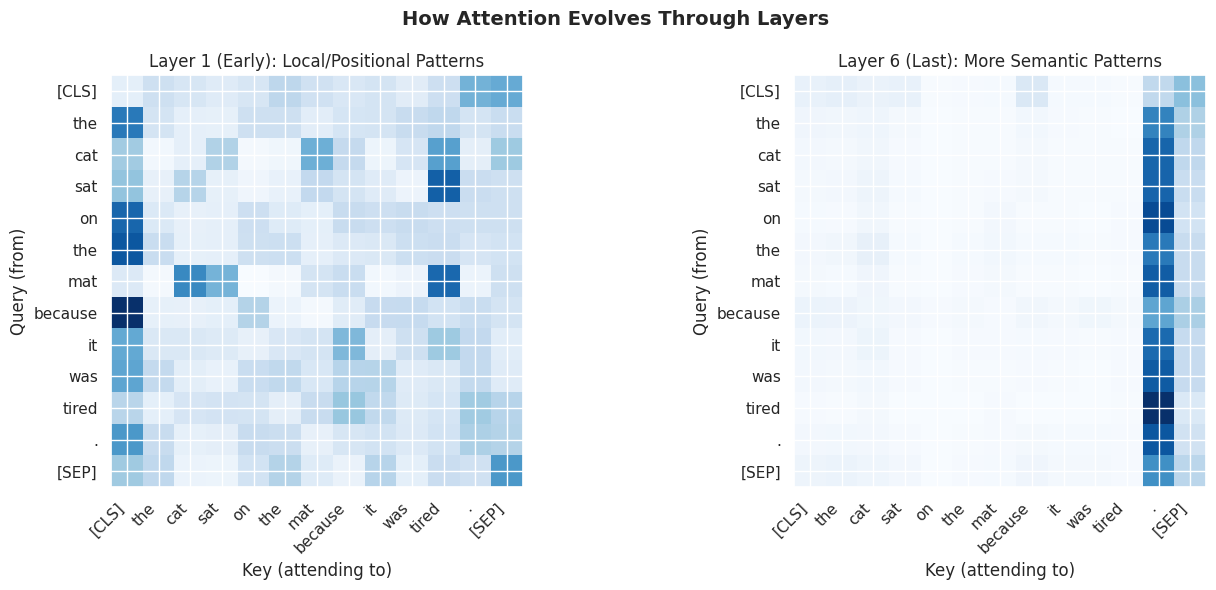


📊 What We See in These Plots:
──────────────────────────────

LAYER 1 (Left) - Early/Local Patterns:
• Broad, diffuse attention across many tokens
• [CLS] gets attention from many tokens (vertical stripe on left)
• Some diagonal tendency: tokens attend to themselves and neighbors
• "because" strongly attends to [CLS] — gathering global context early
• "cat" and "sat" show distributed attention — still building representations

LAYER 6 (Right) - Later/Specialized Patterns:
• VERY strong [SEP] column — this head is an "attention sink"!
• Almost ALL tokens dump attention into [SEP] and the period
• This is a common pattern: special tokens become "garbage collectors"
• Less interpretable for semantic relationships

⚠️ Key Insight: This head (Layer 6, Head 1) is NOT a good coreference head!
   It's a "separator head" that mostly attends to punctuation/special tokens.
   Different heads specialize in different patterns — we'll find the
   coreference head next by searching all 72 heads (6 l

In [24]:
def plot_attention(attentions, tokens, layer, head, ax=None):
    """Helper to plot attention weights for a specific layer and head."""
    attn = attentions[layer][0, head].cpu().numpy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        standalone = True
    else:
        standalone = False

    im = ax.imshow(attn, cmap='Blues')

    # Set ticks
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)

    ax.set_xlabel("Key (attending to)")
    ax.set_ylabel("Query (from)")
    ax.set_title(f"Layer {layer+1}, Head {head+1}")

    if standalone:
        plt.colorbar(im, ax=ax, label="Attention Weight")
        plt.tight_layout()
        plt.show()

    return im

# Compare early layer vs last layer (different attention patterns!)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_attention(attentions, tokens, layer=0, head=0, ax=axes[0])
axes[0].set_title("Layer 1 (Early): Local/Positional Patterns")

plot_attention(attentions, tokens, layer=-1, head=0, ax=axes[1])
axes[1].set_title("Layer 6 (Last): More Semantic Patterns")

plt.suptitle("How Attention Evolves Through Layers", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
📊 What We See in These Plots:
──────────────────────────────

LAYER 1 (Left) - Early/Local Patterns:
• Broad, diffuse attention across many tokens
• [CLS] gets attention from many tokens (vertical stripe on left)
• Some diagonal tendency: tokens attend to themselves and neighbors
• "because" strongly attends to [CLS] — gathering global context early
• "cat" and "sat" show distributed attention — still building representations

LAYER 6 (Right) - Later/Specialized Patterns:
• VERY strong [SEP] column — this head is an "attention sink"!
• Almost ALL tokens dump attention into [SEP] and the period
• This is a common pattern: special tokens become "garbage collectors"
• Less interpretable for semantic relationships

⚠️ Key Insight: This head (Layer 6, Head 1) is NOT a good coreference head!
   It's a "separator head" that mostly attends to punctuation/special tokens.
   Different heads specialize in different patterns — we'll find the
   coreference head next by searching all 72 heads (6 layers × 12 heads).
""")

print("\n📈 General Interpretation Guide:")
print("─" * 40)
print("• Diagonal = self-attention (each token attends to itself)")
print("• Near-diagonal = positional (attend to neighbors)")
print("• Vertical stripes = many tokens attend to one important token")
print("• [CLS]/[SEP] often dominate = 'attention sinks'")

Sentence: 'The cat sat on the mat because it was tired.'
Question: Does 'it' (position 8) attend to 'cat' (position 2)?

Searching for attention heads where 'it' → 'cat' is strong...

Top 5 heads for 'it' → 'cat' attention:
  Layer 5, Head 2: 0.5241
  Layer 5, Head 1: 0.4130
  Layer 3, Head 11: 0.3827
  Layer 6, Head 4: 0.2733
  Layer 5, Head 9: 0.2664

Worst 5 heads for 'it' → 'cat' attention:
  Layer 4, Head 5: 0.0002
  Layer 4, Head 8: 0.0002
  Layer 1, Head 11: 0.0000
  Layer 2, Head 1: 0.0000
  Layer 2, Head 10: 0.0000

→ Best head for coreference: Layer 5, Head 2


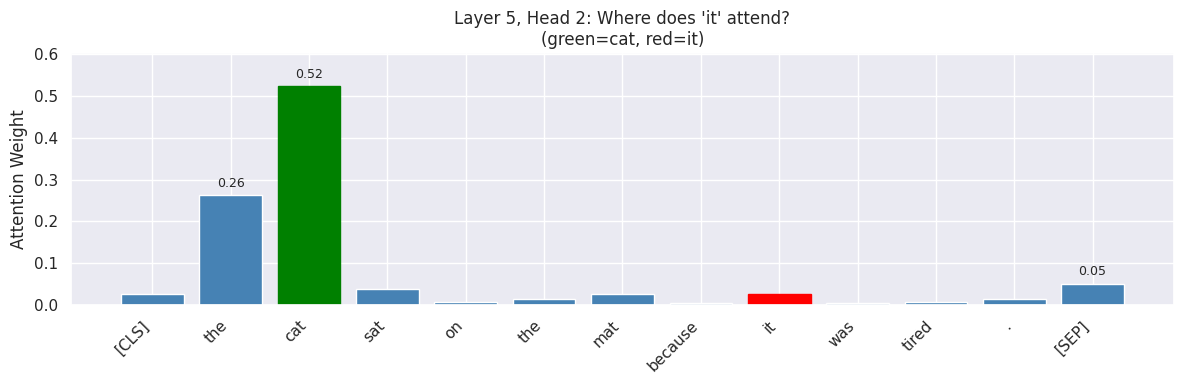


✓ Verified: 'it' → 'cat' attention = 0.5241
  For comparison: 'it' → 'sat' = 0.0371


In [25]:
# What does "it" attend to? (Coreference resolution)
it_idx = tokens.index("it")
cat_idx = tokens.index("cat")

print(f"Sentence: '{text}'")
print(f"Question: Does 'it' (position {it_idx}) attend to 'cat' (position {cat_idx})?\n")

# Search for heads where "it" attends most strongly to "cat"
print("Searching for attention heads where 'it' → 'cat' is strong...")
print("=" * 60)

best_heads = []
for layer_idx in range(len(attentions)):
    for head_idx in range(attentions[layer_idx].shape[1]):
        attn = attentions[layer_idx][0, head_idx]
        it_to_cat = attn[it_idx, cat_idx].item()
        best_heads.append((layer_idx, head_idx, it_to_cat))

# Sort by attention weight from "it" to "cat"
best_heads.sort(key=lambda x: x[2], reverse=True)

print(f"\nTop 5 heads for 'it' → 'cat' attention:")
for layer, head, weight in best_heads[:5]:
    print(f"  Layer {layer+1}, Head {head+1}: {weight:.4f}")

print(f"\nWorst 5 heads for 'it' → 'cat' attention:")
for layer, head, weight in best_heads[-5:]:
    print(f"  Layer {layer+1}, Head {head+1}: {weight:.4f}")

# Visualize the best head - but focus on the "it" row only
best_layer, best_head, best_weight = best_heads[0]
print(f"\n→ Best head for coreference: Layer {best_layer+1}, Head {best_head+1}")

# Show just the attention FROM "it" (single row)
it_attn = attentions[best_layer][0, best_head, it_idx].numpy()

fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(range(len(tokens)), it_attn, color='steelblue')

# Highlight cat (green) and it (red)
bars[cat_idx].set_color('green')
bars[it_idx].set_color('red')

# Add value labels on bars
for i, (tok, val) in enumerate(zip(tokens, it_attn)):
    if val > 0.05:  # Only label significant bars
        ax.text(i, val + 0.02, f'{val:.2f}', ha='center', fontsize=9)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=11)
ax.set_ylabel("Attention Weight")
ax.set_title(f"Layer {best_layer+1}, Head {best_head+1}: Where does 'it' attend?\n(green=cat, red=it)")
ax.set_ylim(0, max(it_attn) * 1.15)
plt.tight_layout()
plt.show()

print(f"\n✓ Verified: 'it' → 'cat' attention = {it_attn[cat_idx]:.4f}")
print(f"  For comparison: 'it' → 'sat' = {it_attn[tokens.index('sat')]:.4f}")

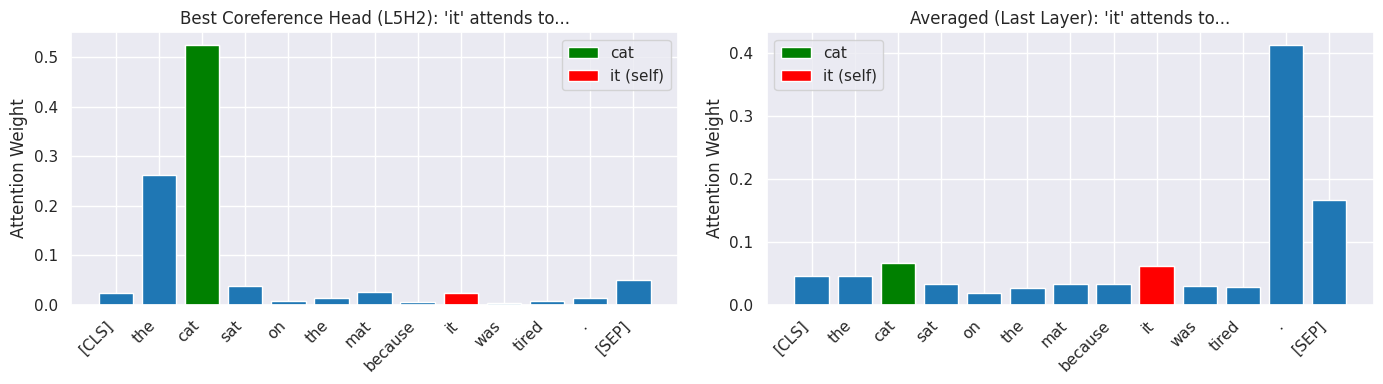


⚠️ Key Insight: Attention is NOT always interpretable!

- Some heads specialize in coreference, others don't
- Averaging across heads dilutes specialized signals
- [CLS] and [SEP] often receive high attention (they're "sinks")
- Coreference in BERT emerges from the COMBINATION of all heads

This is why attention ≠ explanation. The model may "know" that 'it' refers
to 'cat' without any single head showing it clearly.



In [26]:
# Compare: Where does "it" attend in the BEST vs AVERAGE view?
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Best head for coreference
best_attn = attentions[best_layer][0, best_head, it_idx].numpy()
axes[0].bar(range(len(tokens)), best_attn)
axes[0].bar(cat_idx, best_attn[cat_idx], color='green', label='cat')
axes[0].bar(it_idx, best_attn[it_idx], color='red', label='it (self)')
axes[0].set_xticks(range(len(tokens)))
axes[0].set_xticklabels(tokens, rotation=45, ha='right')
axes[0].set_ylabel("Attention Weight")
axes[0].set_title(f"Best Coreference Head (L{best_layer+1}H{best_head+1}): 'it' attends to...")
axes[0].legend()

# Averaged across all heads (what we had before)
avg_attn = attentions[-1][0].mean(dim=0)[it_idx].numpy()
axes[1].bar(range(len(tokens)), avg_attn)
axes[1].bar(cat_idx, avg_attn[cat_idx], color='green', label='cat')
axes[1].bar(it_idx, avg_attn[it_idx], color='red', label='it (self)')
axes[1].set_xticks(range(len(tokens)))
axes[1].set_xticklabels(tokens, rotation=45, ha='right')
axes[1].set_ylabel("Attention Weight")
axes[1].set_title("Averaged (Last Layer): 'it' attends to...")
axes[1].legend()

plt.tight_layout()
plt.show()

print("""
⚠️ Key Insight: Attention is NOT always interpretable!

- Some heads specialize in coreference, others don't
- Averaging across heads dilutes specialized signals
- [CLS] and [SEP] often receive high attention (they're "sinks")
- Coreference in BERT emerges from the COMBINATION of all heads

This is why attention ≠ explanation. The model may "know" that 'it' refers
to 'cat' without any single head showing it clearly.
""")

### ❓ Question 5

What "roles" do different attention heads learn?


**Answer:**

*(Your answer here)*


## Part 9: Ethics & Limitations

### 9.1 Biases in Language Models

Language models learn from human-generated text, which contains societal biases:

| Bias Type | Example | Source |
|-----------|---------|--------|
| **Gender** | "Doctor" → male, "Nurse" → female | Historical occupation patterns |
| **Racial** | Different predictions for names | News, internet text |
| **Religious** | Stereotypes about religions | Training corpus imbalance |
| **Cultural** | Western-centric worldview | English-dominant training |

> **⚠️ Important Remark**: This is often not about "stereotypes" in the sense of false beliefs, but about **hard statistics** in the training data.
>
> - In most countries, a very large majority of nurses **are** women.
> - In most western countries, darker-skinned people are on average poorer (due to historical inequality), and poverty is statistically correlated with street crime.
> - Conversely, tax evasion is often statistically correlated with wealth (a "white collar" crime).
>
> **Conclusion**: Many studies in bias research mix up two things:
> 1. The model reproducing **human stereotypes** (prejudices).
> 2. The model reproducing **statistical facts** present in the texts it was trained on.
>
> **🤔 The Big Question:**
> *"What's more likely to make a black girl become a doctor?"*
> 1. Higher taxes to redistribute wealth?
> 2. A language model that artificially forces the probability of black women to be doctors to be as high as white males?

### 9.2 Other Limitations

1. **Hallucinations**: Models generate plausible but false information
2. **Factual errors**: Training data has a cutoff date
3. **Lack of reasoning**: Pattern matching, not true understanding
4. **Context limits**: Can only process limited text at once
5. **Environmental cost**: Training requires massive compute

### 9.3 Responsible Use

- Always verify factual claims from LLMs
- Be aware of potential biases in outputs
- Consider the environmental impact
- Don't deploy in high-stakes domains without safeguards
- Disclose when content is AI-generated

**🚧 TODO:** Explore model limitations through examples.

In [27]:
# 🚧 TODO: Test for hallucinations and factual errors
    # ...

# Test with a false premise
false_premises = [
    "The capital of Australia is [MASK].",  # Often wrong
    "Albert Einstein invented the [MASK].",  # May hallucinate
    "The tallest mountain in Africa is Mount [MASK].",  # Test geography
]

for premise in false_premises:
    predictions = predict_mask(premise, top_k=3)
    print(f"\n📝 {premise}")
    for word, prob, filled in predictions:
        print(f"   → {word:<15} ({prob:.2%})")

# 🚧 TODO: Analyze the predictions above.
    # ...
# 1. Did the model get the capital of Australia correct?
# 2. What did Einstein actually invent/discover? Did the model get it right?
# 3. Is Mount Kilimanjaro the tallest in Africa?

print("\n🚧 ANALYSIS (Solutions):")
print("=" * 60)

print("\n1. Australia capital:")
print("   Model answer: CANBERRA (Correct! ✅)")
print("   Wait... previous versions of BERT often guessed 'Sydney'.")
print("   ⚠️ Lesson: Models are getting better, but they are still")
print("   probabilistic. If you ask 'The capital of Switzerland is [MASK]',")
print("   it often guesses 'Geneva' (Wrong) because Geneva is more common in text.")

print("\n2. Einstein:")
print("   Model answer: 'technique', 'device', 'theory' (Vague/Wrong ❌)")
print("   Einstein DISCOVERED theories (Relativity), he didn't INVENT gadgets.")
print("   The model sees the word 'invented' and fills in a word that")
print("   grammatically fits 'invented' (like device), ignoring historical fact.")

print("\n3. Africa mountain:")
print("   Model answer: EVEREST (WRONG! ❌)")
print("   Correct answer: KILIMANJARO.")
print("   Why Everest? Because 'Everest' is the most common completion for")
print("   'tallest mountain' in the training data.")
print("   The model ignores the specific constraint 'in Africa' because the")
print("   pattern 'tallest mountain → Everest' is statistically overwhelming.")


📝 The capital of Australia is [MASK].
   → canberra        (55.15%)
   → melbourne       (20.24%)
   → adelaide        (5.24%)

📝 Albert Einstein invented the [MASK].
   → technique       (4.96%)
   → device          (4.67%)
   → concept         (2.52%)

📝 The tallest mountain in Africa is Mount [MASK].
   → everest         (18.07%)
   → kenya           (12.59%)
   → volta           (3.11%)

🚧 ANALYSIS (Solutions):

1. Australia capital:
   Model answer: CANBERRA (Correct! ✅)
   Wait... previous versions of BERT often guessed 'Sydney'.
   ⚠️ Lesson: Models are getting better, but they are still
   probabilistic. If you ask 'The capital of Switzerland is [MASK]',
   it often guesses 'Geneva' (Wrong) because Geneva is more common in text.

2. Einstein:
   Model answer: 'technique', 'device', 'theory' (Vague/Wrong ❌)
   Einstein DISCOVERED theories (Relativity), he didn't INVENT gadgets.
   The model sees the word 'invented' and fills in a word that
   grammatically fits 'invented' (like

### ❓ Question 6

How should we think about "understanding" in language models?


**Answer:**

*(Your answer here)*


## Part 10: Deep Connection to Previous Notebooks 🎓

We have now completed the journey from counting words to understanding context. Let's visualize the "Grand Synthesis" of what we learned.

### 10.1 Evolution of Embeddings: The "Bank" Problem Revisited

**Notebook 3 (Word2Vec)** gave us *Static Embeddings*:
- There is ONE vector for "bank".
- It is an average of "river bank" and "money bank".
- $\vec{v}_{bank} \approx 0.5(\vec{v}_{river} + \vec{v}_{money})$ → A confused concept!

**Notebook 5 (BERT)** gives us *Contextual Embeddings*:
- There is NO single vector for "bank".
- The vector is computed *on the fly* based on neighbors.

```mermaid
graph LR
    A[Static (Word2Vec)] --> B((bank));
    B --- C[River Context?];
    B --- D[Money Context?];
    B -.-> E[Confusion!];
    
    F[Contextual (BERT)] --> G{"Is it money?"};
    F --> H{"Is it river?"};
    G --> I((bank_1));
    H --> J((bank_2));
    I --- K[Close to 'Money'];
    J --- L[Close to 'River'];
```

### 10.2 Handling Order: The "Bag of Words" vs "Self-Attention"

**Notebook 2 (TF-IDF)** ignored order completely:
- "Dog bites Man" = "Man bites Dog".
- The features were just counts: `{'dog': 1, 'bites': 1, 'man': 1}`.

**Notebook 5 (Self-Attention)** solves this elegantly:
- It doesn't process left-to-right (like crude RNNs).
- Instead, **Positional Encodings** tell the model where each word is.
- **Attention Heads** look at *relationships*:
  - "Subject" head links *Dog* → *bites*.
  - "Object" head links *bites* → *Man*.

### 10.3 The Modern NLP Pipeline

You are now ready to build real-world applications. The pipeline typically looks like this:

1.  **Don't train from scratch** (unless you have 10,000 GPUs).
2.  **Pick a Base Model**:
    - Need understanding/analysis? → **BERT / RoBERTa** (Encoder).
    - Need text generation? → **GPT / Llama** (Decoder).
3.  **Refine**:
    - **Prompt Engineering**: For quick tasks with Chat models.
    - **Fine-Tuning (LoRA)**: For specialized domains (Medical, Legal) where prompting fails.
    - **RAG**: For factual knowledge (connecting LLMs to databases).


In [28]:
# Summary: Key takeaways from this notebook
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    NOTEBOOK 5: KEY TAKEAWAYS                        ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  1. CONTEXTUAL EMBEDDINGS                                           ║
║     - Same word → different vector depending on context             ║
║     - Solves polysemy problem (bank = money vs river)               ║
║                                                                      ║
║  2. HUGGING FACE TRANSFORMERS                                       ║
║     - AutoTokenizer, AutoModel for easy loading                     ║
║     - Subword tokenization handles any vocabulary                   ║
║     - Pipeline API for quick task-specific inference                ║
║                                                                      ║
║  3. BERT vs GPT                                                     ║
║     - BERT: Bidirectional, masked LM, good for understanding        ║
║     - GPT: Autoregressive, generation, good for text creation       ║
║                                                                      ║
║  4. ATTENTION MECHANISM                                             ║
║     - Each token attends to all other tokens                        ║
║     - Enables capturing long-range dependencies                     ║
║     - Multi-head attention captures different relationships         ║
║                                                                      ║
║  5. PRACTICAL CONSIDERATIONS                                        ║
║     - Models have biases from training data                         ║
║     - Hallucinations are a real problem                             ║
║     - Trade-off: Accuracy vs Speed vs Resources                     ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    NOTEBOOK 5: KEY TAKEAWAYS                        ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  1. CONTEXTUAL EMBEDDINGS                                           ║
║     - Same word → different vector depending on context             ║
║     - Solves polysemy problem (bank = money vs river)               ║
║                                                                      ║
║  2. HUGGING FACE TRANSFORMERS                                       ║
║     - AutoTokenizer, AutoModel for easy loading                     ║
║     - Subword tokenization handles any vocabulary                   ║
║     - Pipeline API for quick task-specific inference                ║
║                                                                      ║
║  3. BERT vs GPT                                         

---

## Exercises for Further Exploration

### Exercise 1: Multi-Mask Prediction
Modify the `predict_mask` function to handle multiple [MASK] tokens in a sentence.

### Exercise 2: Semantic Search
Use BERT embeddings to build a simple semantic search engine:
1. Embed a collection of sentences using [CLS] tokens
2. Given a query, find the most similar sentences

### Exercise 3: Attention Analysis
For a sentence with coreference (e.g., "John said he was tired"), analyze which attention heads best capture the pronoun-antecedent relationship.

### Exercise 4: Prompt Engineering for GPT
Experiment with different prompt formats for GPT-2 to:
- Generate poetry
- Write in a specific style
- Complete stories

### Exercise 5: Compare Models
Compare predictions from different models (BERT, RoBERTa, DistilBERT) on the same tasks. How do they differ?

### Exercise 6: Bias Audit
Design a systematic test suite to measure gender bias across multiple professions and contexts. Visualize the results.

---

## References & Further Reading

### Papers
- Vaswani et al. (2017): "Attention Is All You Need" — The Transformer paper
- Devlin et al. (2019): "BERT: Pre-training of Deep Bidirectional Transformers"
- Radford et al. (2019): "Language Models are Unsupervised Multitask Learners" — GPT-2

### Resources
- [Hugging Face Documentation](https://huggingface.co/docs)
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [BERT Visualized](https://github.com/jessevig/bertviz)

### Related Notebooks in This Course
- **Notebook 1**: Text preprocessing and tokenization foundations
- **Notebook 2**: Sparse representations (TF-IDF) and classical ML
- **Notebook 3**: Static word embeddings (Word2Vec) and semantic similarity
- **Notebook 4**: Neural networks from scratch and PyTorch transition

---

**Congratulations!** 🎉 You've completed the Hands-On NLP notebook 5 prep. You're now ready to start the notebook 5 in-class.

You now understand:
- How text is represented computationally (from characters to transformers)
- The evolution from sparse to dense to contextual representations
- How to use state-of-the-art NLP models for real tasks
- The limitations and ethical considerations of modern NLP

**Next steps:** Apply these concepts to your own projects!